<a href="https://colab.research.google.com/github/amitkml/END-NLP-Projects/blob/main/NLPBasic-Session1/Sentiment_Analysis_using_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM based Sentiment Analysis
Let's perform a SVM based Sentiment Analysis based on Support a Vector Machine Model on Twitter Sentiments of US Airline passengers.

**Fill in the blanks**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

from sklearn.svm import SVC

In [ ]:
url = 'https://raw.githubusercontent.com/amitkml/END-NLP-Projects/main/NLPBasic-Session1/Tweets_Airline.csv'
data = pd.read_csv(url, error_bad_lines=False)

## Import data


In [ ]:
# data = pd.read_csv("Tweets_Airline.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## We take only the tweets we are very confident with. We use the BeautifulSoup library to process html encoding present in some tweets.

In [ ]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

In [ ]:
data_clean.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_clean
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),@VirginAmerica What @dhepburn said.
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica and it's a really big bad thing...
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica seriously would pay $30 a fligh...


## For simplicity we are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

In [ ]:
# lambda x : (false,true)[Condition]
# https://stackoverflow.com/questions/15772617/conditional-statement-in-a-one-line-lambda-function-in-python

data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x : (0,1)[x == 'negative']) #Hint: Assign 1 to negative class and 0 to rest
# data_clean['sentiment'] = data_clean['airline_sentiment'].apply(--Fill--) #Hint: Assign 1 to negative class and 0 to rest
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


## We split the data into training and testing set:

In [ ]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

## Preprocessing the Data

# TweetTokenizer and word_tokenize
- both tokenizers almost work the same way, to split a given sentence into words. But you can think of TweetTokenizer as a subset of word_tokenize. TweetTokenizer keeps hashtags intact while word_tokenize doesn't.
- You can see that word_tokenize has split #dummysmiley as '#' and 'dummysmiley', while TweetTokenizer didn't, as '#dummysmiley'. TweetTokenizer is built mainly for analyzing tweets. You can learn more about tokenizer from this link

In [ ]:
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import  word_tokenize
nltk.download('punkt')

tt = TweetTokenizer()
tweet = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <-- @remy: This is waaaaayyyy too much for you!!!!!!"
print(tt.tokenize(tweet))

print(word_tokenize(tweet))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--', '@remy', ':', 'This', 'is', 'waaaaayyyy', 'too', 'much', 'for', 'you', '!', '!', '!']
['This', 'is', 'a', 'cooool', '#', 'dummysmiley', ':', ':', '-', ')', ':', '-P', '<', '3', 'and', 'some', 'arrows', '<', '>', '-', '>', '<', '--', '@', 'remy', ':', 'This', 'is', 'waaaaayyyy', 'too', 'much', 'for', 'you', '!', '!', '!', '!', '!', '!']


# CountVectorizer

- CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text
- You can use it as follows:
    Create an instance of the CountVectorizer class.
    - Call the fit() function in order to learn a vocabulary from one or more documents.
    - Call the transform() function on one or more documents as needed to encode each as a vector.
- An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

In [ ]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

## We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline.

In [ ]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                                             kernel= "linear", 
                                             class_weight= "balanced")) #Hint : Linear kernel with balanced class weights

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.5min finished


0.9188979138877743

In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 0.1}
0.9025857063886015


## Let's see how the model (with the best hyperparameters) works on the test data:

In [ ]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.8337605272793849,
 'auc': 0.9188967089480032,
 'f1': 0.8690888119953863,
 'precision': 0.9133333333333333,
 'recall': 0.828932893289329}

## ROC Curve

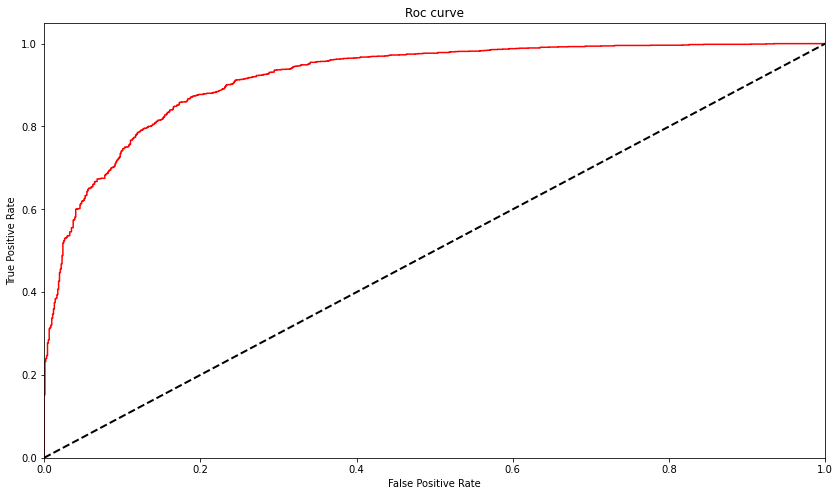

In [ ]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

## Prediction

In [ ]:
pred = grid_svm.predict(["flying with @united is always a great experience."])
print('negative' if pred == np.array([1]) else 'not negative')

not negative


In [ ]:
pred = grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])
print('negative' if pred == np.array([1]) else 'not negative')

negative


**It easily distinguishes the text based on context!!**

# More experiments

- Change Kernel from linear to poly

In [ ]:

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                                             kernel= "poly", 
                                             class_weight= "balanced")) #Hint : Linear kernel with balanced class weights

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.0min finished


0.8651925433507206

In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 1}
0.8489064200738579


In [ ]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.6938850238008055,
 'auc': 0.8651609136817298,
 'f1': 0.7213333333333332,
 'precision': 0.9153976311336718,
 'recall': 0.5951595159515951}

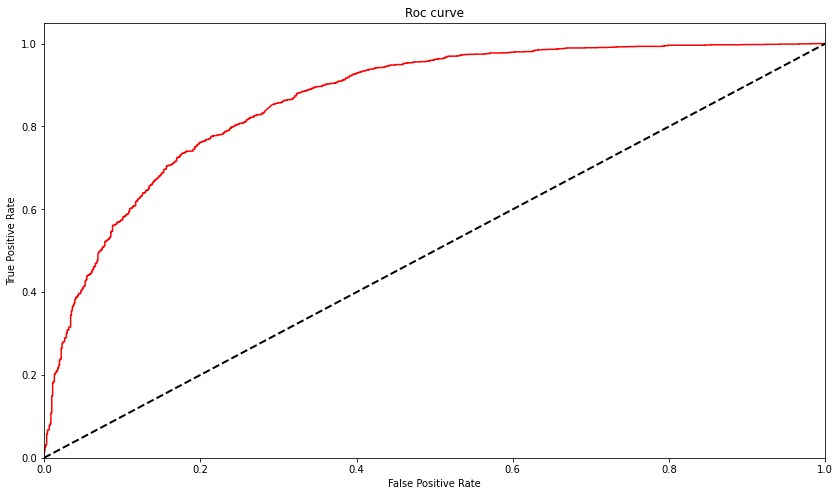

In [ ]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

# More Experiments
- Lets understand frequency distribution of data for positive and negative sentiments

In [ ]:
df = pd.Series(data_clean.sentiment).value_counts()       
print(df / len(data_clean)) 

1    0.643689
0    0.356311
Name: sentiment, dtype: float64


In [ ]:
# class_weight={0: 1, 1: 2}

In [ ]:
pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                                             kernel= "poly", 
                                             class_weight= {0: 2, 1: 1})) #Hint : Linear kernel with balanced class weights

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.1min finished


0.864541273404449

In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 1}
0.8472161098231179


In [ ]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.6909556938850238,
 'auc': 0.8645578413263012,
 'f1': 0.7171581769436999,
 'precision': 0.9176672384219554,
 'recall': 0.5885588558855885}

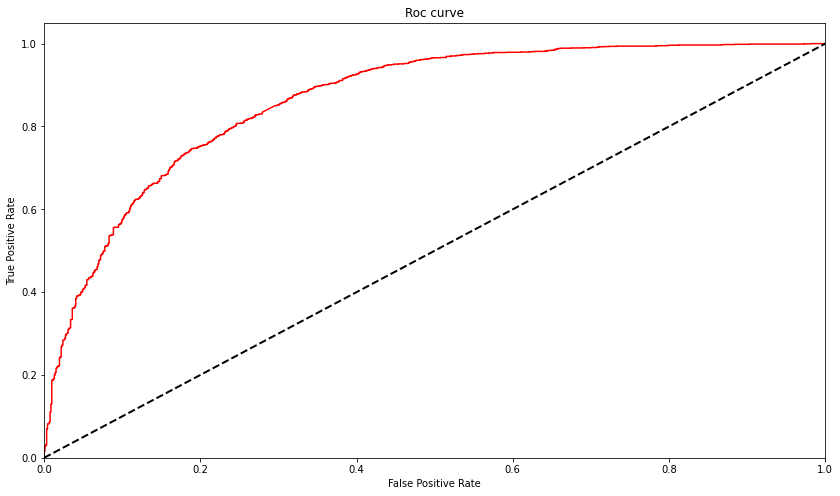

In [ ]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()